In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# `Prediction`

In [ ]:
df1 = pd.read_csv('cleaned_gdp2.csv')
df2 = pd.read_csv('internet_users2.csv')

plt.figure(figsize=(12, 6))

for country in df1['Country'].unique():
    gdp_data = df1[df1['Country'] == country].drop(columns=['Country']).values.flatten()
    years = np.arange(2010, 2010+len(gdp_data))

    users_data = df2[df2['Country'] == country].drop(columns=['Country']).values.flatten()

    nan_indices_gdp = pd.isnull(gdp_data)
    nan_indices_users = pd.isnull(users_data)

    if nan_indices_gdp.all() or nan_indices_users.all():
        continue

    nan_indices_combined = nan_indices_gdp | nan_indices_users
    gdp_data = gdp_data[~nan_indices_combined]
    users_data = users_data[~nan_indices_combined]
    years = years[~nan_indices_combined]

    assert gdp_data.shape == users_data.shape == years.shape, f"GDP, Users, and Years data shapes don't match for {country}"

    gdp_model = LinearRegression()
    gdp_model.fit(years.reshape(-1, 1), gdp_data)

    users_model = LinearRegression()
    users_model.fit(years.reshape(-1, 1), users_data)

    future_years = np.arange(2021, 2031)
    future_gdp = gdp_model.predict(future_years.reshape(-1, 1))
    future_users = users_model.predict(future_years.reshape(-1, 1))

    plt.plot(years, gdp_data, label=f'{country} - GDP')
    plt.plot(future_years, future_gdp, linestyle='--', label=f'{country} - Predicted GDP')

    plt.plot(years, users_data, label=f'{country} - Users')
    plt.plot(future_years, future_users, linestyle='--', label=f'{country} - Predicted Users')

plt.title('GDP and Users Predictions')
plt.xlabel('Year')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.xticks(np.arange(2010, 2031, 1))
plt.tight_layout()

plt.show()


# Correlation

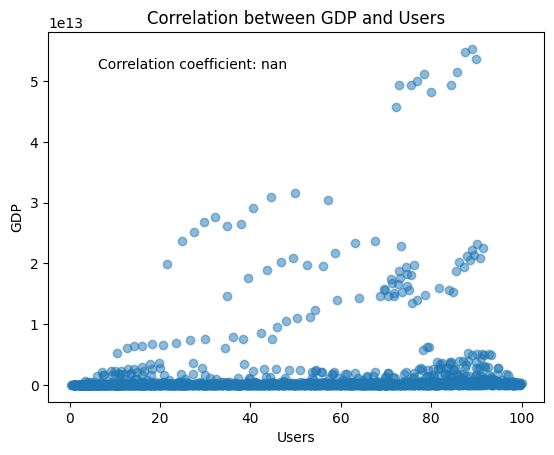

In [6]:
merged_df = pd.merge(df1, df2, on='Country', suffixes=('_GDP', '_Users'))

gdp_data = merged_df.iloc[:, 1:12].values.flatten()
users_data = merged_df.iloc[:, 12:].values.flatten()

correlation_coefficient = np.corrcoef(gdp_data, users_data)[0, 1]

plt.scatter(users_data, gdp_data, alpha=0.5)
plt.title('Correlation between GDP and Users')
plt.xlabel('Users')
plt.ylabel('GDP')
plt.text(0.1, 0.9, f'Correlation coefficient: {correlation_coefficient:.2f}', transform=plt.gca().transAxes)
plt.show()


# Heatmap

<ipython-input-7-75f82ddc24a7>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = merged_df.corr()


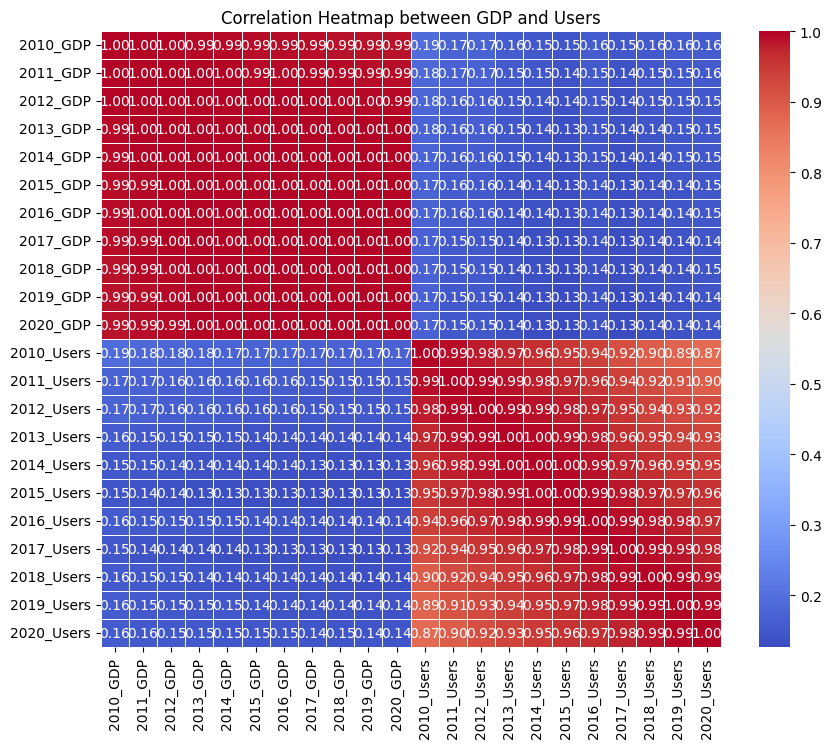

In [7]:
import seaborn as sns

correlation_matrix = merged_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap between GDP and Users')
plt.show()

# Ramdon Forest

In [37]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Load data
df1 = pd.read_csv('cleaned_gdp2.csv')
df2 = pd.read_csv('internet_users2.csv')

# Initialize lists to store results
error_margin_list = []
accuracy_list = []
growth_2010_to_2020_list = []
growth_prediction_2021_to_2031_list = []
mse_list = []

for country in df1['Country'].unique():
    # Prepare data for the specific country
    gdp_data = df1[df1['Country'] == country].drop(columns=['Country']).values.flatten()
    users_data = df2[df2['Country'] == country].drop(columns=['Country']).values.flatten()

    # Check if both GDP and users data exist for the country
    if len(gdp_data) == 0 or len(users_data) == 0:
        continue

    years = np.arange(2010, 2010 + len(gdp_data))

    # Remove NaN values
    nan_indices_gdp = pd.isnull(gdp_data)
    nan_indices_users = pd.isnull(users_data)
    nan_indices_combined = nan_indices_gdp | nan_indices_users
    gdp_data = gdp_data[~nan_indices_combined]
    users_data = users_data[~nan_indices_combined]
    years = years[~nan_indices_combined]

    # Check if there are enough samples for fitting the model
    if len(gdp_data) < 2 or len(users_data) < 2:
        continue

    # Random Forest Regression for GDP
    gdp_model = RandomForestRegressor(n_estimators=100, random_state=42)
    gdp_model.fit(years.reshape(-1, 1), gdp_data)

    # Predictions for the next ten years (2021-2031)
    future_years = np.arange(2021, 2031)
    future_gdp = gdp_model.predict(future_years.reshape(-1, 1))

    # Calculate error margin and accuracy
    predictions = gdp_model.predict(years.reshape(-1, 1))
    mse = mean_squared_error(gdp_data, predictions)
    rmse = np.sqrt(mse)
    accuracy = 100 - (rmse / np.mean(gdp_data) * 100)

    # Calculate R-squared (R2)
    r2 = r2_score(gdp_data, predictions)

    # Append results to lists
    error_margin_list.append(rmse)
    accuracy_list.append(accuracy)
    mse_list.append(mse)

    # Calculate growth percentage from 2010 to 2020
    growth_percentage_2010_to_2020 = ((gdp_data[-1] - gdp_data[0]) / gdp_data[0]) * 100
    growth_2010_to_2020_list.append(growth_percentage_2010_to_2020)

    # Calculate growth prediction from 2021 to 2031
    growth_prediction_2021_to_2031_list.append((future_gdp[-1] / future_gdp[0]) * 100)

# Compute total values
total_error_margin = np.mean(error_margin_list)
total_accuracy = np.mean(accuracy_list)
total_growth_2010_to_2020 = np.mean(growth_2010_to_2020_list)
total_growth_prediction_2021_to_2031 = np.mean(growth_prediction_2021_to_2031_list)
total_mse = np.mean(mse_list)

# Print the results
print("Total Error Margin (RMSE):", total_error_margin)
print("Total Accuracy (%):", total_accuracy)
print("Total Growth Percentage 2010-2020:", total_growth_2010_to_2020)
print("Total Growth Prediction 2021-2031:", total_growth_prediction_2021_to_2031)
print("Total Mean Squared Error (MSE):", total_mse)


Total Error Margin (RMSE): 25899841621.84911
Total Accuracy (%): 96.80847573705108
Total Growth Percentage 2010-2020: 34.95276051141517
Total Growth Prediction 2021-2031: 100.0
Total Mean Squared Error (MSE): 1.0432942887647043e+22


# GradientBoostingRegressor


In [44]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Load data
df1 = pd.read_csv('cleaned_gdp2.csv')
df2 = pd.read_csv('internet_users2.csv')

# Initialize lists to store results
error_margin_list = []
accuracy_list = []
growth_2010_to_2020_list = []
growth_prediction_2021_to_2031_list = []
mse_list = []  # Store MSE for each country
r2_list = []   # Store R-squared for each country

for country in df1['Country'].unique():
    # Prepare data for the specific country
    gdp_data = df1[df1['Country'] == country].drop(columns=['Country']).values.flatten()
    users_data = df2[df2['Country'] == country].drop(columns=['Country']).values.flatten()

    # Check if both GDP and users data exist for the country
    if len(gdp_data) == 0 or len(users_data) == 0:
        continue

    years = np.arange(2010, 2010 + len(gdp_data))

    # Remove NaN values
    nan_indices_gdp = pd.isnull(gdp_data)
    nan_indices_users = pd.isnull(users_data)
    nan_indices_combined = nan_indices_gdp | nan_indices_users
    gdp_data = gdp_data[~nan_indices_combined]
    users_data = users_data[~nan_indices_combined]
    years = years[~nan_indices_combined]

    # Check if there are enough samples for fitting the model
    if len(gdp_data) < 2 or len(users_data) < 2:
        continue

    # Gradient Boosting Regression for GDP
    gdp_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
    gdp_model.fit(years.reshape(-1, 1), gdp_data)

    # Predictions for the next ten years (2021-2031)
    future_years = np.arange(2021, 2031)
    future_gdp = gdp_model.predict(future_years.reshape(-1, 1))

    # Calculate error margin and accuracy
    predictions = gdp_model.predict(years.reshape(-1, 1))
    mse = mean_squared_error(gdp_data, predictions)
    rmse = np.sqrt(mse)
    accuracy = 100 - (rmse / np.mean(gdp_data) * 100)

    # Append results to lists
    error_margin_list.append(rmse)
    accuracy_list.append(accuracy)

    # Calculate growth percentage from 2010 to 2020
    growth_percentage_2010_to_2020 = ((gdp_data[-1] - gdp_data[0]) / gdp_data[0]) * 100
    growth_2010_to_2020_list.append(growth_percentage_2010_to_2020)

    # Calculate growth prediction from 2021 to 2031
    growth_prediction_2021_to_2031_list.append((future_gdp[-1] / future_gdp[0]) * 100)

    # Calculate R-squared
    r2 = r2_score(gdp_data, predictions)
    r2_list.append(r2)
    mse_list.append(mse)

# Compute total values
total_error_margin = np.mean(error_margin_list)
total_accuracy = np.mean(accuracy_list)
total_growth_2010_to_2020 = np.mean(growth_2010_to_2020_list)
total_growth_prediction_2021_to_2031 = np.mean(growth_prediction_2021_to_2031_list)
total_mse = np.mean(mse_list)
total_r2 = np.mean(r2_list)

# Print the results
print("Total Error Margin (RMSE):", total_error_margin)
print("Total Accuracy (%):", total_accuracy)
print("Total Growth Percentage 2010-2020:", total_growth_2010_to_2020)
print("Total Growth Prediction 2021-2031:", total_growth_prediction_2021_to_2031)
print("Total Mean Squared Error (MSE):", total_mse)
print("Total R-squared (R2):", total_r2)


Total Error Margin (RMSE): 63444926.620414525
Total Accuracy (%): 99.99040885193713
Total Growth Percentage 2010-2020: 34.95276051141517
Total Growth Prediction 2021-2031: 100.0
Total Mean Squared Error (MSE): 5.48956615990587e+16
Total R-squared (R2): 0.9999951562190865


# Linear Regression

In [34]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Load data
df1 = pd.read_csv('cleaned_gdp2.csv')
df2 = pd.read_csv('internet_users2.csv')

# Initialize lists to store results
error_margin_list = []
accuracy_list = []
growth_2010_to_2020_list = []
growth_prediction_2021_to_2031_list = []

for country in df1['Country'].unique():
    # Prepare data for the specific country
    gdp_data = df1[df1['Country'] == country].drop(columns=['Country']).values.flatten()
    users_data = df2[df2['Country'] == country].drop(columns=['Country']).values.flatten()

    # Check if both GDP and users data exist for the country
    if len(gdp_data) == 0 or len(users_data) == 0:
        continue

    years = np.arange(2010, 2010 + len(gdp_data))

    # Remove NaN values
    nan_indices_gdp = pd.isnull(gdp_data)
    nan_indices_users = pd.isnull(users_data)
    nan_indices_combined = nan_indices_gdp | nan_indices_users
    gdp_data = gdp_data[~nan_indices_combined]
    users_data = users_data[~nan_indices_combined]
    years = years[~nan_indices_combined]

    # Check if there are enough samples for fitting the model
    if len(gdp_data) < 2 or len(users_data) < 2:
        continue

    # Linear Regression for GDP
    gdp_model = LinearRegression()
    gdp_model.fit(years.reshape(-1, 1), gdp_data)

    # Predictions for the next ten years (2021-2031)
    future_years = np.arange(2021, 2031)
    future_gdp = gdp_model.predict(future_years.reshape(-1, 1))

    # Calculate error margin and accuracy
    predictions = gdp_model.predict(years.reshape(-1, 1))
    mse = mean_squared_error(gdp_data, predictions)
    rmse = np.sqrt(mse)
    accuracy = 100 - (rmse / np.mean(gdp_data) * 100)

    # Append results to lists
    error_margin_list.append(rmse)
    accuracy_list.append(accuracy)

    # Calculate growth percentage from 2010 to 2020
    growth_percentage_2010_to_2020 = ((gdp_data[-1] - gdp_data[0]) / gdp_data[0]) * 100
    growth_2010_to_2020_list.append(growth_percentage_2010_to_2020)

    # Calculate growth prediction from 2021 to 2031
    growth_prediction_2021_to_2031_list.append((future_gdp[-1] / future_gdp[0]) * 100)

# Compute total values
total_error_margin = np.mean(error_margin_list)
total_accuracy = np.mean(accuracy_list)
total_growth_2010_to_2020 = np.mean(growth_2010_to_2020_list)
total_growth_prediction_2021_to_2031 = np.mean(growth_prediction_2021_to_2031_list)

# Print the results
print("Total Error Margin (RMSE):", total_error_margin)
print("Total Accuracy (%):", total_accuracy)
print("Total Growth Percentage 2010-2020:", total_growth_2010_to_2020)
print("Total Growth Prediction 2021-2031:", total_growth_prediction_2021_to_2031)

Total Error Margin (RMSE): 50133003379.94194
Total Accuracy (%): 92.8548247145674
Total Growth Percentage 2010-2020: 34.95276051141517
Total Growth Prediction 2021-2031: 126.68598979791582


# GDP Growth

To estimate the increase in GDP from 2020 to 2030 based on our predictions, we'll first need to calculate the predicted GDP for each country for the year 2030 using our Random Forest model. Then, we can sum up all these predicted GDP values to get an overall estimate of the total GDP increase across all countries.

In [60]:
import pandas as pd
from sklearn.linear_model import LinearRegression

# Assuming cleaned_gdp2 is a DataFrame with columns: 'Country', '2010', '2011', ..., '2020'
# You need to have the cleaned_gdp2 DataFrame loaded or defined properly before running this code

# Reshape DataFrame from wide to long format
cleaned_gdp2 = pd.read_csv("cleaned_gdp2.csv")
melted_data = cleaned_gdp2.melt(id_vars=['Country'], var_name='Year', value_name='GDP')

# Convert 'Year' column to numeric
melted_data['Year'] = pd.to_numeric(melted_data['Year'])

# Filter data for years 2010 to 2020
filtered_data = melted_data[(melted_data['Year'] >= 2010) & (melted_data['Year'] <= 2020)]

# Calculate total GDP for each year
total_gdp_by_year = filtered_data.groupby('Year').agg({'GDP': 'sum'})

# Calculate GDP growth from 2010 to 2020
initial_gdp = total_gdp_by_year.loc[2010, 'GDP']
final_gdp = total_gdp_by_year.loc[2020, 'GDP']
total_growth = ((final_gdp - initial_gdp) / initial_gdp) * 100

# Train a simple linear regression model to predict total GDP growth for the next ten years
X_train = total_gdp_by_year.index.values.reshape(-1, 1)
y_train = total_gdp_by_year['GDP'].values

model = LinearRegression()
model.fit(X_train, y_train)

# Predict total GDP for the next ten years
future_years = [year for year in range(2021, 2031)]
X_future = pd.DataFrame({'Year': future_years})
predicted_gdp = model.predict(X_future)

# Display total GDP growth from 2010 to 2020 and predicted total GDP for the next ten years
print("Total GDP growth from 2010 to 2020: {:.2f}%".format(total_growth))

print("\nPredicted total GDP for the next ten years:")
predicted_data = pd.DataFrame({'Year': future_years, 'Predicted GDP': predicted_gdp})
print(predicted_data)

print(f"The prediction for the next 10 years is of:", predicted_data["Predicted GDP"].sum())


Total GDP growth from 2010 to 2020: 30.81%

Predicted total GDP for the next ten years:
   Year  Predicted GDP
0  2021   6.473419e+14
1  2022   6.604570e+14
2  2023   6.735722e+14
3  2024   6.866873e+14
4  2025   6.998024e+14
5  2026   7.129176e+14
6  2027   7.260327e+14
7  2028   7.391478e+14
8  2029   7.522630e+14
9  2030   7.653781e+14
The prediction for the next 10 years is of: 7063600099356360.0


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


In [61]:
# Calculate the total predicted GDP growth for the next 10 years
predicted_growth_percentage = ((predicted_gdp[-1] - predicted_gdp[0]) / predicted_gdp[0]) * 100
rounded_predicted_growth_percentage = round(predicted_growth_percentage, 2)

# Display the total predicted GDP growth for the next 10 years as a rounded percentage
print(f"The predicted total GDP growth for the next 10 years is: {rounded_predicted_growth_percentage}%")


The predicted total GDP growth for the next 10 years is: 18.23%


In [63]:
import pandas as pd
from sklearn.linear_model import LinearRegression

# Assuming cleaned_gdp2 is a DataFrame with columns: 'Country', '2010', '2011', ..., '2023'
# You need to have the cleaned_gdp2 DataFrame loaded or defined properly before running this code

# Reshape DataFrame from wide to long format
melted_data = cleaned_gdp2.melt(id_vars=['Country'], var_name='Year', value_name='GDP')

# Convert 'Year' column to numeric
melted_data['Year'] = pd.to_numeric(melted_data['Year'])

# Filter data for years 2010 to 2023
filtered_data = melted_data[(melted_data['Year'] >= 2010) & (melted_data['Year'] <= 2023)]

# Calculate total GDP for each year
total_gdp_by_year = filtered_data.groupby('Year').agg({'GDP': 'sum'})

# Train a simple linear regression model to predict total GDP growth for the next seven years (2024 to 2030)
X_train = total_gdp_by_year.index.values.reshape(-1, 1)
y_train = total_gdp_by_year['GDP'].values

model = LinearRegression()
model.fit(X_train, y_train)

# Predict total GDP for the next seven years (2024 to 2030)
future_years = [year for year in range(2024, 2031)]
X_future = pd.DataFrame({'Year': future_years})
predicted_gdp = model.predict(X_future)

# Display predicted total GDP for the next seven years
predicted_data = pd.DataFrame({'Year': future_years, 'Predicted GDP': predicted_gdp})
print("Predicted total GDP for the years 2024 to 2030:")
print(predicted_data)

# Calculate the total predicted GDP growth for the next 10 years
predicted_growth_percentage = ((predicted_gdp[-1] - predicted_gdp[0]) / predicted_gdp[0]) * 100
rounded_predicted_growth_percentage = round(predicted_growth_percentage, 2)

# Display the total predicted GDP growth for the next 6 years as a rounded percentage
print(f"The predicted total GDP growth for the next 6 years is: {rounded_predicted_growth_percentage}%")


Predicted total GDP for the years 2024 to 2030:
   Year  Predicted GDP
0  2024   6.866873e+14
1  2025   6.998024e+14
2  2026   7.129176e+14
3  2027   7.260327e+14
4  2028   7.391478e+14
5  2029   7.522630e+14
6  2030   7.653781e+14
The predicted total GDP growth for the next 6 years is: 11.46%


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


In [55]:
total_gdp_2010 = merged_df['2010_GDP'].sum()
total_gdp_2020 = merged_df['2020_GDP'].sum()
percentage_growth = ((total_gdp_2020 - total_gdp_2010) / total_gdp_2010) * 100

print(f"The estimated percentage growth in total GDP from 2010 to 2020 is: {percentage_growth:.2f}%")


The estimated percentage growth in total GDP from 2010 to 2020 is: 30.42%


In [57]:
predicted_data.head()

,Year,Predicted GDP
0,2024,6.866873e+14
1,2025,6.998024e+14
2,2026,7.129176e+14
3,2027,7.260327e+14
4,2028,7.391478e+14


In [65]:
predicted_data.to_csv("prediction.csv")